In [1]:
from fastai.vision.all import *

# 1.数据集准备

In [2]:
path = untar_data(URLs.MNIST)
print(f"数据下载路径在：{path}")

数据下载路径在：C:\Users\28576\.fastai\data\mnist_png


In [5]:
# 检查数据目录
if not (path/"training").exists() or not (path/"testing").exists():
    raise FileNotFoundError("训练数据目录不存在，请检查数据下载是否成功。")

# 查看训练集和测试集的子目录
print([d.name for d in path.iterdir() if d.is_dir()])

['testing', 'training']


In [10]:
print("训练集图片数量：",len(list((path/"training").glob('*/*.png'))))
print("测试集图片数量：",len(list((path/"testing").glob('*/*.png'))))

训练集图片数量： 60000
测试集图片数量： 10000


# 2.准备模型
- 创建一个简单的CNN模型

In [ ]:
model = sequential(
    # 第一个卷积层，输入通道1，输出通道32，卷积核大小3x3，步长1，输入图像大小1*28*28
    ConvLayer(1, 32, stride=1, ks=3), # 输入通道1，输出通道32，卷积核大小3x3，步长1，32*26*26
    ConvLayer(32, 64, stride=1, ks=3), # 输入通道32，输出通道64，卷积核大小3x3，步长1,64*24*24
    
    # 自适应池化层到7X7，64*7*7
    AdaptiveAvgPool(7),
    
    # 展平层，将多维输入一维化，64*7*7=>3136
    Flatten(),
    
    # 全连接层，输入特征64*7*7，输出特征128
    nn.Linear(64*7*7, 128),
    nn.ReLU(), # 激活函数和随机失活，用于引入非线性并防止过拟合。
    nn.Dropout(0.5), # Dropout层，防止过拟合,p=0.5表示50%的概率丢弃
    nn.Linear(128, 10) # 输出层，10个类别
)
model

Sequential(
  (0): ConvLayer(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): AdaptiveAvgPool2d(output_size=7)
  (3): fastai.layers.Flatten(full=False)
  (4): Linear(in_features=3136, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
dls = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), # 输入是黑白图像，输出是类别标签
    get_items=get_image_files, # 获取图像文件
    splitter=GrandparentSplitter(train_name="training", valid_name="testing"),
    get_y=parent_label,
    item_tfms=[Resize(28)], # 处理单一图形的变化，如统一尺寸
    batch_tfms=[Normalize.from_stats(0.5, 0.5)] # 用于批量处理图片，如标准化、批量翻转/旋转/调整亮度等
)

In [18]:
dbb = dls.dataloaders(path, bs=128)

In [20]:
learn = Learner(dbb, model, 
                loss_func=CrossEntropyLossFlat(), # 交叉熵损失
                metrics=[accuracy, error_rate]) # 评估指标：准确率和错误率

建议的学习率：0.0002290867705596611


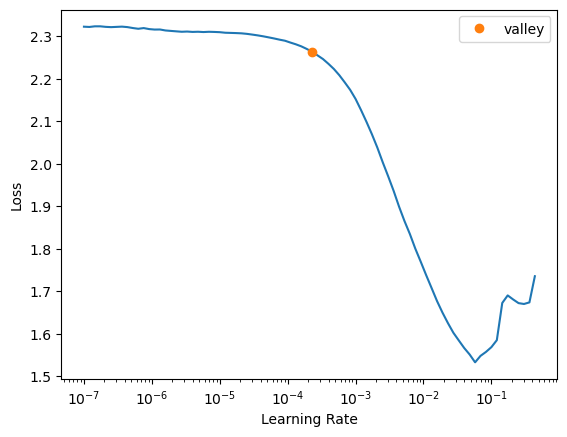

In [22]:
sge = learn.lr_find().valley
print(f"建议的学习率：{sge}")

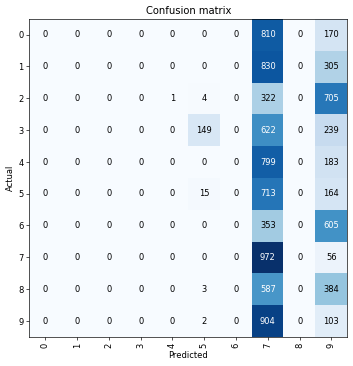

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.063192,0.046703,0.985200,0.014800,02:15
1,0.057186,0.031031,0.991700,0.008300,02:18
2,0.035287,0.025097,0.992200,0.007800,02:45
3,0.025011,0.018928,0.994700,0.005300,02:29
4,0.016959,0.018668,0.995100,0.004900,02:15


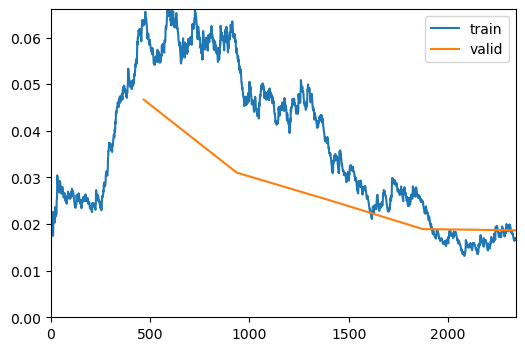

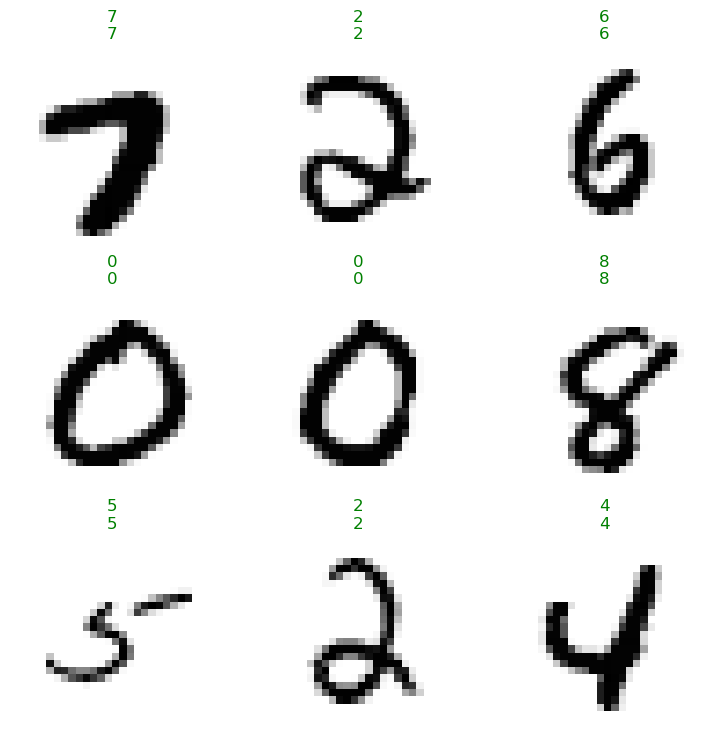

In [ ]:
# 使用fit_one_cycle进行训练
learn.fit_one_cycle(
    5,          # 训练5个epoch
    lr_max=1e-2, # 最大学习率为0.01
    cbs=ShowGraphCallback() # 回调函数，用于显示训练过程中的损失函数曲线
)
# # 展示预测结果，默认显示前9个
# learn.show_results()

## 评估模型性能

In [32]:
# 1.在验证集上评估，其实就是使用fit_one_cycle训练完后自动评估的结果
valid_loss, accuracy_val, error_rate_val = learn.validate()
print(f"验证集损失: {valid_loss:.4f}")
print(f"验证集准确率: {accuracy_val:.4f}")
print(f"验证集错误率: {error_rate_val:.4f}")

验证集损失: 0.0187
验证集准确率: 0.9951
验证集错误率: 0.0049


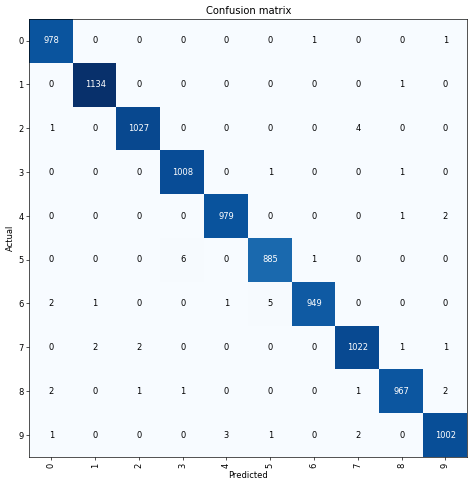

In [33]:
# 2.训练后的准确率和混淆矩阵
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

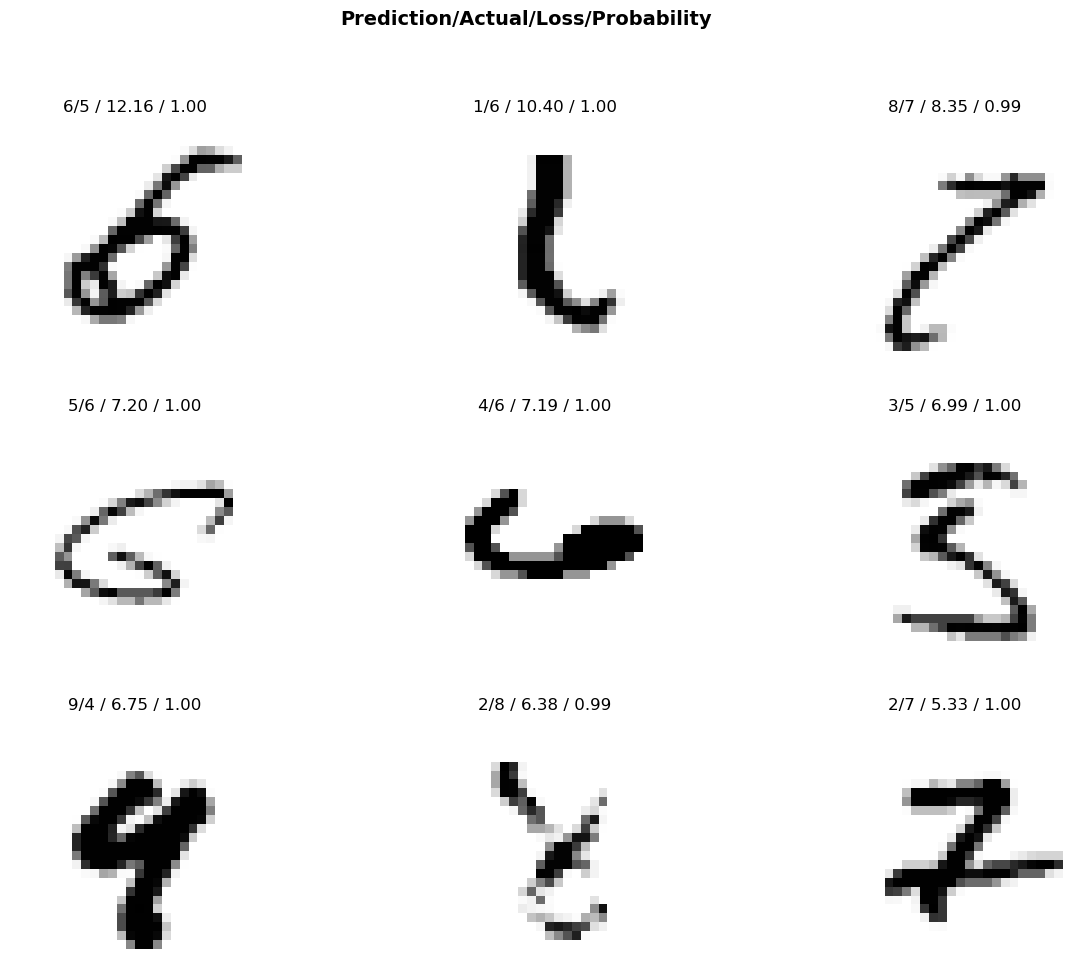

In [34]:
# 3.显示不确定的样本
interp.plot_top_losses(9, figsize=(15,11))

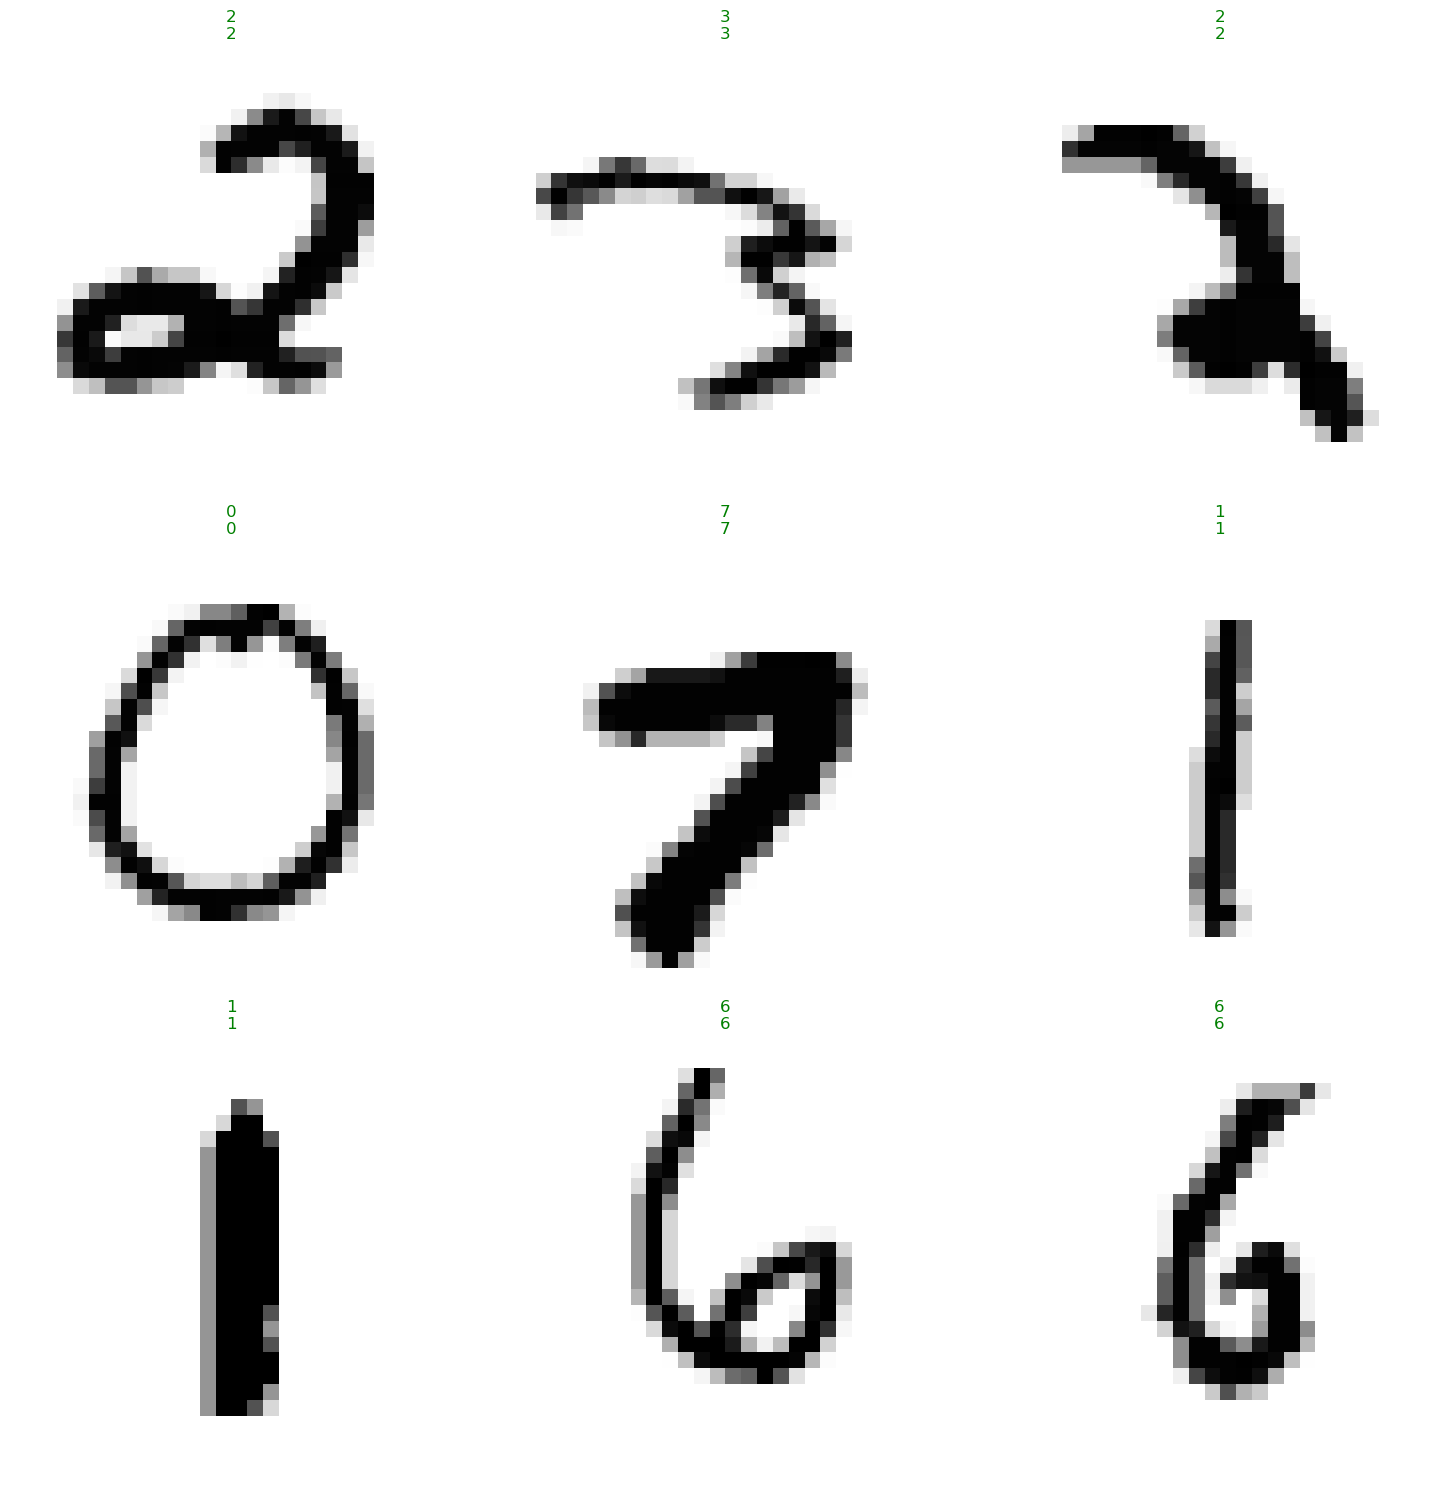

In [42]:
# 使用更大的图显示预测结果
learn.show_results(max_n=9, figsize=(15, 15)) #显示前9个预测结果
plt.tight_layout() # 调整子图之间的间距
plt.show() # 显示图像

In [ ]:
# 获取预测结果并计算详细指标
preds, targets = learn.get_preds() # 都返回(N,1)的张量
predicted_labels = preds.argmax(dim=1)

In [52]:
print(len(targets.numpy()))
print(len(preds.numpy()))
print(len(predicted_labels.numpy()))

10000
10000
10000


In [39]:
from sklearn.metrics import classification_report
import numpy as np

In [ ]:
report = classification_report(
    targets.numpy(), # 实际标签
    predicted_labels.numpy(),  # 预测标签
    target_names=[str(i) for i in range(10)],  # 类别名称，共10类，标签0-9
    digits=4  # 显示小数点后4位
)

In [47]:
print("\n详细分类报告:")
print(report)


详细分类报告:
              precision    recall  f1-score   support

           0     0.9939    0.9980    0.9959       980
           1     0.9974    0.9991    0.9982      1135
           2     0.9971    0.9952    0.9961      1032
           3     0.9931    0.9980    0.9956      1010
           4     0.9959    0.9969    0.9964       982
           5     0.9922    0.9922    0.9922       892
           6     0.9979    0.9906    0.9942       958
           7     0.9932    0.9942    0.9937      1028
           8     0.9959    0.9928    0.9943       974
           9     0.9940    0.9931    0.9936      1009

    accuracy                         0.9951     10000
   macro avg     0.9951    0.9950    0.9950     10000
weighted avg     0.9951    0.9951    0.9951     10000



In [ ]:
# 打印每个类别的样本数量
unique_labels, counts = np.unique(targets.numpy(), return_counts=True) # 获取每个类别的样本数量
print("\n每个类别的样本数量:")
for label, count in zip(unique_labels, counts):
    print(f"类别 {label}: {count} 个样本")


每个类别的样本数量:
类别 0: 980 个样本
类别 1: 1135 个样本
类别 2: 1032 个样本
类别 3: 1010 个样本
类别 4: 982 个样本
类别 5: 892 个样本
类别 6: 958 个样本
类别 7: 1028 个样本
类别 8: 974 个样本
类别 9: 1009 个样本
